In [71]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [72]:
!ls ../resized_img/ -1 | head -4

dung1.jpg
dung2.jpg
dung3.jpg
dung4.jpg


## Step 1: Đọc ảnh đầu vào

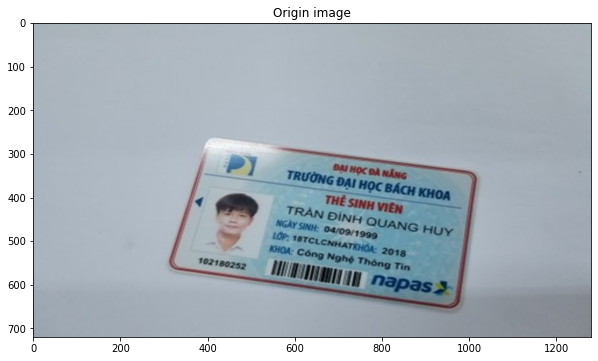

In [73]:
img = cv2.imread("../resized_img/huy2.jpg")
img = cv2.resize(img, (1280, 720))
plt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # for display in note-book only

plt.figure(figsize=(10, 10))
plt.title("Origin image")
plt.imshow(plt_img)
plt.show()

## Step 2: Chuyển về ảnh xám, áp dụng thuật toán phân ngưỡng threshold để tách biệt nền với phần ảnh thẻ (ROI)

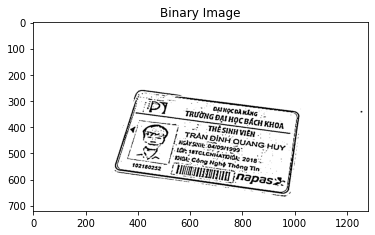

In [74]:
# remove noise with Gaussian Filter
img = cv2.GaussianBlur(img, (5,5), 0)
# cvt to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# apply threshold for detect ROI (Region of Interest)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 3)

thresh_ = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB) # for display in note-book only
plt.imshow(thresh_)
plt.title("Binary Image")
plt.show()

> Vẽ các contours ra để kiểm tra

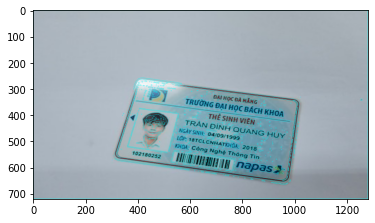

In [75]:
# find all contours
contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# grab contours
contours = imutils.grab_contours(contours)
# draw all contours for debug
clone_img = plt_img.copy()
cv2.drawContours(clone_img, contours, -1, (0,255,255), 1)

# plt.figure(figsize=(100, 100))
plt.imshow(clone_img)

## Step 3: Xấp xỉ contour lớn nhất (ngoại trừ cái viền) bằng một tập điểm đa giác nhằm tìm 4 góc của thẻ

In [76]:
# sort function
def sort_by_area(contour):
    (_, _, w, h) = cv2.boundingRect(contour)
    return w * h
# sort all contours by are
contours = sorted(contours, key=sort_by_area, reverse=True)
# pick the second one
c = contours[1]
# calculate arc length
peri = cv2.arcLength(c, True)
# approximate the shape of contour with multiple points
approx = cv2.approxPolyDP(c, 0.01 * peri, True)
approx = np.asarray([p[0] for p in approx])

> Vẽ các điểm của đa giác để kiểm tra

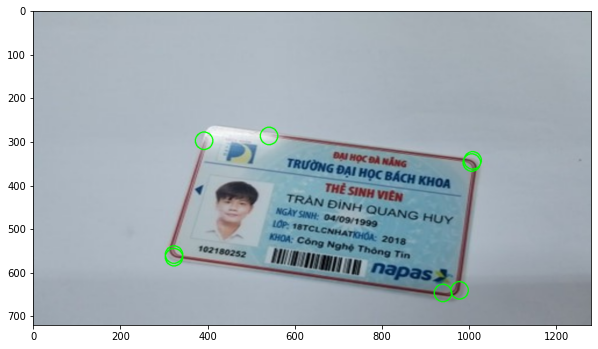

In [77]:
clone_img2 = plt_img.copy()
for p in approx:
    x, y = p
    cv2.circle(clone_img2, (x,y), 20, (0,255,0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(clone_img2)

## Step 4: Lọc ra 4 điểm đại diện cho 4 góc của thẻ

In [78]:
# find 4 corner points
sum_approx = np.sum(approx, axis=1)
diff_approx = np.diff(approx, axis=1)
corner_points = np.array([
#     top_left
    approx[np.argmin(sum_approx)] + [-20, -20],
#     top_right
    approx[np.argmin(diff_approx)] + [20, -20],
#     bottom_right
    approx[np.argmax(sum_approx)] + [20, 20],
#     bottom_left
    approx[np.argmax(diff_approx)] + [-20, 20]
], dtype='float32')

> Vẽ ra 4 điểm được chọn

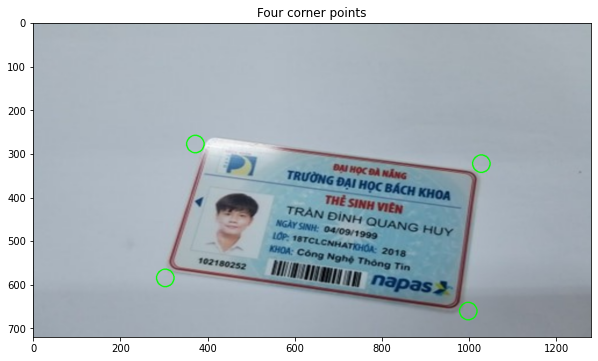

In [79]:
clone_img3 = plt_img.copy()
for p in corner_points:
    x, y = map(int, p)
    cv2.circle(clone_img3, (x,y), 20, (0,255,0), 2)

plt.figure(figsize=(10, 10))
plt.title("Four corner points")
plt.imshow(clone_img3)

### Tính kích thước của ảnh thẻ sẽ cắt ra dựa vào 4 góc

In [80]:
# calculate size of ROI
def calculate_fit_size(corner_pts):
    (tl, tr, br, bl) = corner_pts
#     width
    w1 = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2)
    w2 = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2)
    w = max(int(w1), int(w2))
#     height
    h1 = np.sqrt((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2)
    h2 = np.sqrt((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2)
    h = max(int(h1), int(h2))
#     
    return w, h

## Step 5: Cắt ảnh dựa vào 4 góc và xoay về hướng chính diện

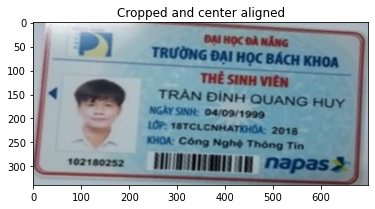

In [81]:
w, h = calculate_fit_size(corner_points)

dst_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
M = cv2.getPerspectiveTransform(corner_points, dst_pts)
aligned = cv2.warpPerspective(plt_img, M, (w, h))

# plt.figure(figsize=(50, 50))
plt.title("Cropped and center aligned")
plt.imshow(aligned)
plt.show()

## Step 6: Sử dụng kết quả này để làm đầu vào cho Detector